# Dimension Reduce digits



In [10]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import scipy
from sklearn import random_projection
from cluster_func import em
from cluster_func import kmeans

In [11]:
def read_dataset(path):
    data = pd.read_csv(path, sep=',')
    instances = len(data.values)
    features = len(data.values[0])-1
    X = data.values[:, 0:features]
    y = data.values[:, features]

    return X, y

In [12]:
X_train, y_train = read_dataset('data/optdigits.tra')

In [13]:
X_test, y_test = read_dataset('data/optdigits.tes')

In [14]:
X_f = X_train
y_f = y_train

In [15]:
#Converting into numpy arrays
# X_train = X_train.values()
# X_test = X_test.values()
# y_train = y_train.values() - 1
# y_test = y_test.values() - 1

# #Preprocessing the data between 0 and 1
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

Starting FA
Dimensionality reduction


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not 

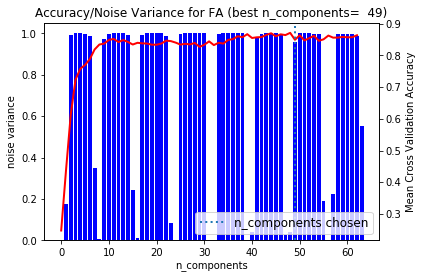

In [16]:
#######################################################################################################################
#######################################################################################################################
# Dimensionality reduction PCA


print("Starting FA")
print("Dimensionality reduction")

decisiontree = DecisionTreeClassifier(criterion = 'gini', max_depth = 15, min_samples_split = 5)
fa = FactorAnalysis(max_iter = 100)

pipe = Pipeline(steps=[('fa', fa), ('decisionTree', decisiontree)])

# Plot the PCA spectrum
fa.fit(X_train)

fig, ax = plt.subplots()
#ax.bar(list(range(1,2)), fa.noise_variance_, linewidth=2, color = 'blue')
ax.bar(np.arange(X_train.shape[1]), fa.noise_variance_, linewidth=2, color = 'blue')
plt.axis('tight')
plt.xlabel('n_components')
ax.set_ylabel('noise variance')

#Checking the accuracy for taking all combination of components
n_components = range(1, X_train.shape[1])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
gridSearch = GridSearchCV(pipe, dict(fa__n_components=n_components), cv = 3)
gridSearch.fit(X_train, y_train)
results = gridSearch.cv_results_
ax1 = ax.twinx()

#Plotting the accuracies and best component
ax1.plot(results['mean_test_score'], linewidth = 2, color = 'red')
ax1.set_ylabel('Mean Cross Validation Accuracy')
ax1.axvline(gridSearch.best_estimator_.named_steps['fa'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)

plt.legend(prop=dict(size=12))
plt.title('Accuracy/Noise Variance for FA (best n_components=  %d)'%gridSearch.best_estimator_.named_steps['fa'].n_components )
plt.show()

#Reducing the dimensions with optimal number of components
fa_new = FactorAnalysis(n_components = gridSearch.best_estimator_.named_steps['fa'].n_components, max_iter = 100)
fa_new.fit(X_train)
X_train_transformed = fa_new.transform(X_train)
X_test_transformed = fa_new.transform(X_test)

Calculating Reconstruction Error


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


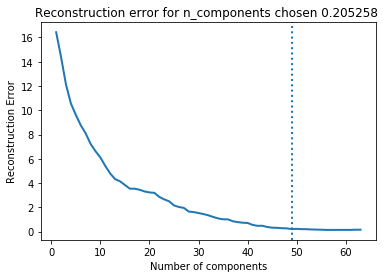

In [17]:
###############################################################################################################################
#Reconstruction Error

print("Calculating Reconstruction Error")

def inverse_transform_fa(fa, X_transformed, X_train):

	return X_transformed.dot(fa.components_) + np.mean(X_train, axis = 0)

reconstruction_error = []

for comp in n_components:

	fa = FactorAnalysis(n_components = comp, max_iter = 100)
	X_transformed = fa.fit_transform(X_train)
	X_projected = inverse_transform_fa(fa, X_transformed, X_train)
	reconstruction_error.append(((X_train - X_projected) ** 2).mean())

	if(comp == gridSearch.best_estimator_.named_steps['fa'].n_components):
		chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
ax2.axvline(gridSearch.best_estimator_.named_steps['fa'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen %f '%chosen_error)
plt.show()

Clustering FA
Expected Maximization
Training accuracy for Expected Maximization for K = 10:  54.44793301936159
Testing accuracy for Expected Maximization for K = 10:  51.28062360801782
KMeans


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Training accuracy for KMeans for K = 10:  88.77551020408163
Testing accuracy for KMeans for K = 10:  86.35857461024499


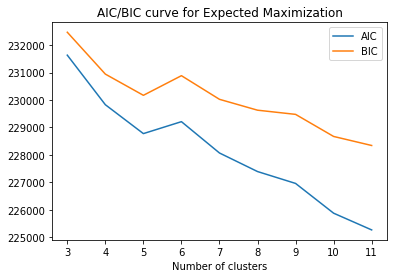

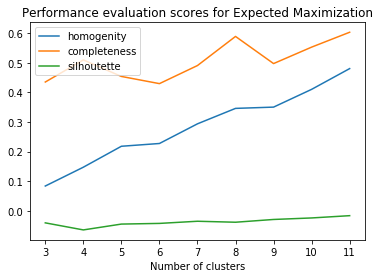

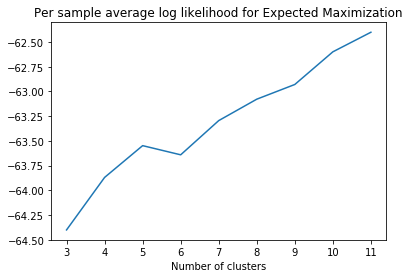

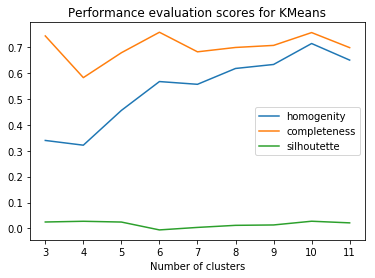

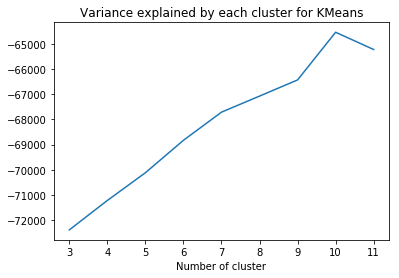

In [19]:
################################################################################################################################
#Clustering after dimensionality reduction

print("Clustering FA")

#Reducing the dimensions with optimal number of components
fa_new = FactorAnalysis(n_components = gridSearch.best_estimator_.named_steps['fa'].n_components, max_iter = 100)
fa_new.fit(X_f)
X_transformed_f = fa_new.transform(X_f)


means_init = np.array([X_transformed_f[y_f == i].mean(axis=0) for i in range(10)])

#clustering experiments
print("Expected Maximization")
component_list, array_aic, array_bic, array_homo_1, array_comp_1, array_sil_1, array_avg_log = em(X_train_transformed, X_test_transformed, y_train, y_test, init_means = means_init, component_list = [3,4,5,6,7,8,9,10,11], num_class = 10, toshow = 0)

print("KMeans")
component_list, array_homo_2, array_comp_2, array_sil_2, array_var = kmeans(X_train_transformed, X_test_transformed, y_train, y_test, init_means = means_init, component_list = [3,4,5,6,7,8,9,10,11], num_class = 10, toshow = 0)



In [20]:
#Writing data to file
component_list = np.array(component_list).reshape(-1,1)
array_aic = np.array(array_aic).reshape(-1,1)
array_bic = np.array(array_bic).reshape(-1,1)
array_homo_1 = np.array(array_homo_1).reshape(-1,1)
array_comp_1 = np.array(array_comp_1).reshape(-1,1)
array_sil_1 = np.array(array_sil_1).reshape(-1,1)
array_avg_log = np.array(array_avg_log).reshape(-1,1)
array_homo_2 = np.array(array_homo_2).reshape(-1,1)
array_comp_2 = np.array(array_comp_2).reshape(-1,1)
array_sil_2 = np.array(array_sil_2).reshape(-1,1)
array_var = np.array(array_var).reshape(-1,1)

reconstruction_error = np.array(reconstruction_error).reshape(-1,1)

data_em_fa_digits = np.concatenate((component_list, array_aic, array_bic, array_homo_1, array_comp_1, array_sil_1, array_avg_log), axis =1)

data_km_fa_digits = np.concatenate((component_list, array_homo_2, array_sil_2, array_var), axis =1)

reconstruction_error_fa_digits = np.concatenate((np.arange(1,X.shape[1]).reshape(-1,1), reconstruction_error), axis = 1)

file = './data/data_em_fa_digits.csv'
with open(file, 'w', newline = '') as output:
	writer = csv.writer(output, delimiter=',')
	writer.writerows(data_em_fa_digits)

file = './data/data_km_fa_digits.csv'
with open(file, 'w', newline = '') as output:
	writer = csv.writer(output, delimiter=',')
	writer.writerows(data_km_fa_digits)

file = './data/reconstruction_error_fa_digits.csv'
with open(file, 'w', newline = '') as output:
	writer = csv.writer(output, delimiter=',')
	writer.writerows(reconstruction_error_fa_digits)

NameError: name 'X' is not defined